# Albany Daily Weather (Northeast Representative)

Target: next-day DailyAverageDryBulbTemperature

This notebook serves as the main entry point for the project.

It demonstrates:
- loading and validating NOAA daily weather data
- feature engineering for time-series forecasting
- preparation of X and y for downstream modeling


In [1]:
import sys
from pathlib import Path

# add project root to Python path
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

In [2]:
from pathlib import Path

from weather.data import WeatherStation
from weather.features import build_features, stream_days
from weather.dataanalyzer import DataAnalyzer

CSV_PATH = Path("../data/daily_data.csv")
DATE_COL = "DATE"
TARGET_COL = "DailyAverageDryBulbTemperature"

In [3]:
ws = WeatherStation(
    csv_path=CSV_PATH,
    station_name="Albany (Representative Northeast Station)",
    date_col=DATE_COL,
    target_col=TARGET_COL,
)

print(ws)
ws.df.head()

WeatherStation(name='Albany (Representative Northeast Station)', rows=2668, range=2015-01-01..2022-05-31, mean=50.11)


,STATION,DATE,REPORT_TYPE,SOURCE,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,...,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,Sunrise,Sunset,WindEquipmentChangeDate
0,72518014735,2015-01-01,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,190.0,26.0,0.00,0.0,0.0,190.0,20.0,726.0,1632.0,2006-09-08
1,72518014735,2015-01-02,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,250.0,30.0,T,0.0,T,310.0,23.0,726.0,1633.0,2006-09-08
2,72518014735,2015-01-03,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,170.0,21.0,0.57,0.0,1.6,160.0,15.0,726.0,1634.0,2006-09-08
3,72518014735,2015-01-04,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,290.0,33.0,0.22,1.0,0.0,290.0,24.0,726.0,1635.0,2006-09-08
4,72518014735,2015-01-05,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,280.0,42.0,T,0.0,T,290.0,32.0,726.0,1636.0,2006-09-08


In [4]:
feat = build_features(ws.df, date_col=DATE_COL, target_col=TARGET_COL)
feat.head()

,STATION,DATE,REPORT_TYPE,SOURCE,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,...,DailyAverageDryBulbTemperature_rollstd_3,DailyAverageDryBulbTemperature_rollmean_7,DailyAverageDryBulbTemperature_rollstd_7,DailyAverageDryBulbTemperature_rollmean_14,DailyAverageDryBulbTemperature_rollstd_14,month,dayofyear,weekday,doy_sin,doy_cos
0,72518014735,2015-01-15,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,13.650397,15.571429,9.071147,20.071429,10.484159,1,15,3,0.255182,0.966893
1,72518014735,2015-01-16,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,5.773503,16.714286,8.280787,19.357143,10.463175,1,16,4,0.271777,0.962360
2,72518014735,2015-01-17,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,8.082904,16.857143,8.355209,18.571429,9.834901,1,17,5,0.288291,0.957543
3,72518014735,2015-01-18,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,5.033223,16.714286,8.459990,17.428571,9.708951,1,18,6,0.304719,0.952442
4,72518014735,2015-01-19,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,10.503968,18.714286,10.274796,16.928571,8.633248,1,19,0,0.321058,0.947060


In [5]:
# next-day target
df2 = feat.copy()
df2["y_next"] = df2[TARGET_COL].shift(-1)
df2 = df2.dropna().reset_index(drop=True)

feature_cols = [c for c in df2.columns if c not in [DATE_COL, TARGET_COL, "y_next"]]
X = df2[feature_cols]
y = df2["y_next"]

X.shape, y.shape

((2653, 45), (2653,))

In [6]:
g = stream_days(df2[[DATE_COL, TARGET_COL]], date_col=DATE_COL)

i = 0
while i < 5:
    d, row = next(g)
    print(d.date(), float(row[TARGET_COL]))
    i += 1

2015-01-15 15.0
2015-01-16 21.0
2015-01-17 11.0
2015-01-18 32.0
2015-01-19 34.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 32 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   STATION                                     2668 non-null   int64         
 1   DATE                                        2668 non-null   datetime64[ns]
 2   REPORT_TYPE                                 2668 non-null   object        
 3   SOURCE                                      2668 non-null   int64         
 4   BackupElements                              2668 non-null   object        
 5   BackupElevation                             2668 non-null   int64         
 6   BackupEquipment                             2668 non-null   object        
 7   BackupLatitude                              2668 non-null   float64       
 8   BackupLongitude                             2668 non-null   float64       
 9   BackupNa

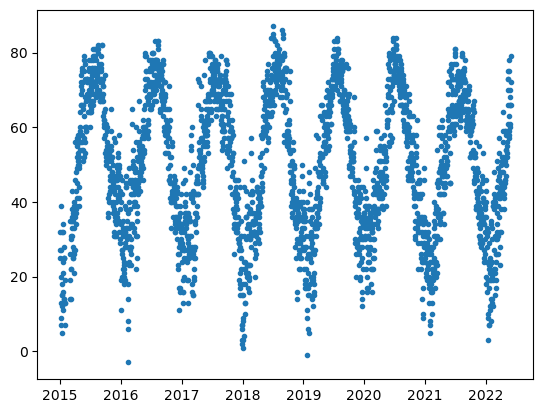

In [7]:
da = DataAnalyzer()
data = ws.df
da.analyze(data)